<a href="https://colab.research.google.com/github/jeonghoya/Machine-Learning-Programming/blob/main/week7/PPG_ONLY_another_patient_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import h5py
import numpy as np
import math
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.signal import butter, filtfilt
import joblib # 스케일러 저장을 위해 추가
import copy # best model 저장을 위해 추가

In [ ]:
def analyze_patient_blood_pressure(file_path):
    """
    선택한 환자 파일의 혈압 데이터를 분석하고 시각화합니다.
    - 최대 2000개 세그먼트의 SBP, DBP 변동을 그래프로 표시합니다.
    - SBP, DBP 값의 분포를 히스토그램으로 보여주고, 권장 범위 충족 비율을 계산합니다.
    """
    print(f"'{file_path}' 파일 분석을 시작합니다...")

    try:
        with h5py.File(file_path, 'r') as f:
            if 'Subj_Wins' not in f or 'SegSBP' not in f['Subj_Wins']:
                print("오류: 파일이 유효한 PulseDB 형식이 아닙니다.")
                return

            # 1. 데이터 로딩 (최대 2000개 세그먼트)
            sbp_refs = f['Subj_Wins']['SegSBP'][0]
            dbp_refs = f['Subj_Wins']['SegDBP'][0]

            num_segments_to_load = min(len(sbp_refs), 2000)

            sbps = np.array([float(f[ref][()][0, 0]) for ref in sbp_refs[:num_segments_to_load]])
            dbps = np.array([float(f[ref][()][0, 0]) for ref in dbp_refs[:num_segments_to_load]])

            print(f"총 {num_segments_to_load}개의 세그먼트를 로드했습니다.")

            # 2. 요구사항: 전 구간 SBP, DBP 그래프 표시
            print("\n요구사항 1: 전체 혈압 변동 그래프를 생성합니다...")
            plt.style.use('seaborn-v0_8-whitegrid')
            plt.figure(figsize=(18, 7))
            plt.plot(sbps, label='SBP (Systolic)', color='red', alpha=0.8, linewidth=1.5)
            plt.plot(dbps, label='DBP (Diastolic)', color='blue', alpha=0.8, linewidth=1.5)
            plt.title(f'Blood Pressure Trend for Patient ({os.path.basename(file_path)})', fontsize=16)
            plt.xlabel('Segment Index', fontsize=12)
            plt.ylabel('Blood Pressure (mmHg)', fontsize=12)
            plt.legend() # <--- FIX 2: 그래프에 범례를 추가합니다.
            plt.show()

            # 3. 요구사항: 혈압 범위 적합성 분석 및 시각화
            print("\n요구사항 2: 혈압 범위 적합성을 분석합니다...")
            avg_sbp = np.mean(sbps)
            avg_dbp = np.mean(dbps)

            # 정상 SBP (90 <= sbp < 130) 비율 계산
            sbp_in_range_pct = np.mean((sbps >= 90) & (sbps < 130)) * 100
            # 정상 DBP (60 <= dbp < 80) 비율 계산
            dbp_in_range_pct = np.mean((dbps >= 60) & (dbps < 80)) * 100

            print("\n--- 혈압 통계 요약 ---")
            print(f"  - 평균 SBP: {avg_sbp:.2f} mmHg")
            print(f"  - 평균 DBP: {avg_dbp:.2f} mmHg")
            print(f"  - 정상 SBP (90-130) 비율: {sbp_in_range_pct:.2f}%")
            print(f"  - 정상 DBP (60-80) 비율: {dbp_in_range_pct:.2f}%")

            # 히스토그램 시각화
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
            fig.suptitle('Blood Pressure Distribution Analysis', fontsize=16)

            ax1.hist(sbps, bins=30, color='coral', edgecolor='black')
            ax1.axvline(90, color='darkgreen', linestyle='--', label='Normal lower bound (90)')
            ax1.axvline(130, color='darkred', linestyle='--', label='Normal upper bound (130)')
            ax1.set_title('SBP Distribution')
            ax1.set_xlabel('SBP (mmHg)')
            ax1.legend()

            ax2.hist(dbps, bins=30, color='skyblue', edgecolor='black')
            ax2.axvline(60, color='darkgreen', linestyle='--', label='Normal lower bound (60)')
            ax2.axvline(80, color='darkred', linestyle='--', label='Normal upper bound (80)')
            ax2.set_title('DBP Distribution')
            ax2.set_xlabel('DBP (mmHg)')
            ax2.legend()

            plt.show()

            # 최종 추천
            print("\n--- 최종 분석 결과 ---")
            if sbp_in_range_pct > 70 and dbp_in_range_pct > 70:
                print("✅ 이 환자는 정상 혈압 범위 조건을 잘 만족하는 훌륭한 후보입니다.")
            elif sbp_in_range_pct > 50 and dbp_in_range_pct > 50:
                print("⚠️ 이 환자는 어느 정도 조건을 만족하지만, 일부 혈압이 범위를 벗어납니다. 사용 가능합니다.")
            else:
                print("❌ 이 환자는 정상 혈압 범위와 차이가 커 보입니다. 다른 환자를 찾아보는 것을 고려해 보세요.")

    except FileNotFoundError:
        print(f"오류: '{file_path}' 파일을 찾을 수 없습니다. 경로를 확인해주세요.")
    except Exception as e:
        print(f"파일 분석 중 오류가 발생했습니다: {e}")

'/content/drive/MyDrive/Colab Notebooks/p001331.mat' 파일 분석을 시작합니다...
총 2000개의 세그먼트를 로드했습니다.

요구사항 1: 전체 혈압 변동 그래프를 생성합니다...


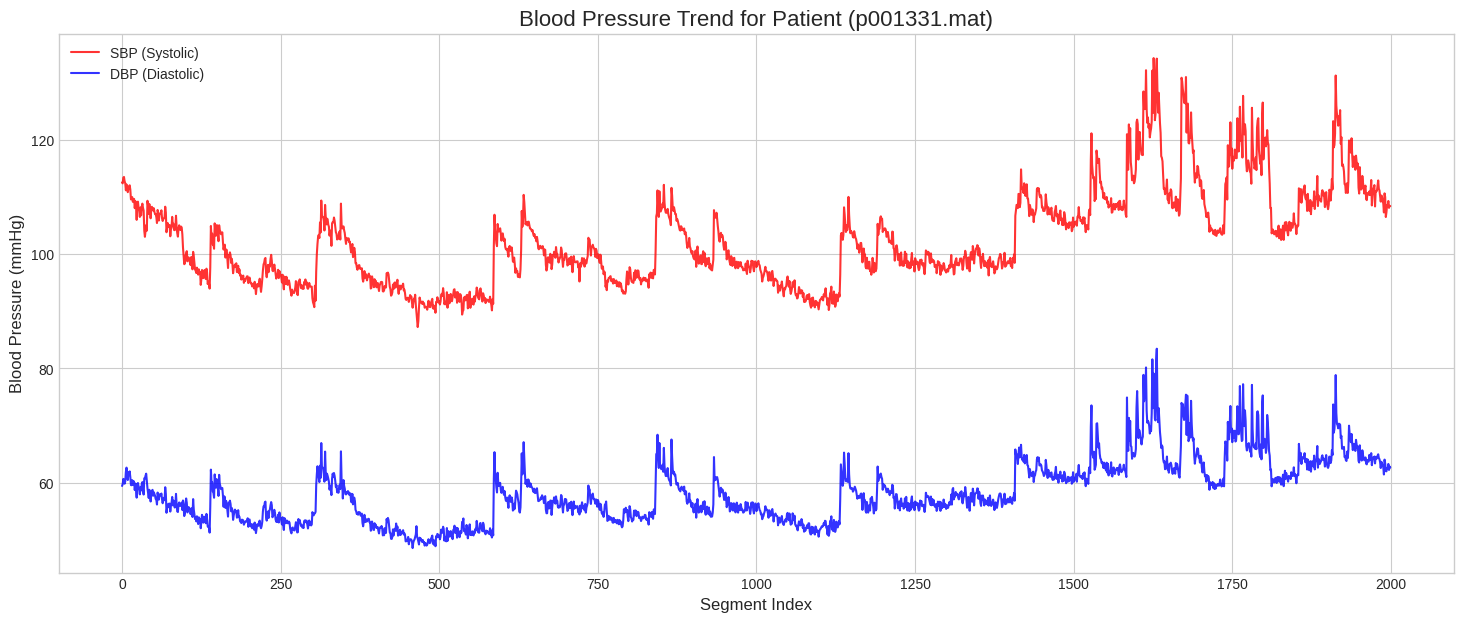


요구사항 2: 혈압 범위 적합성을 분석합니다...

--- 혈압 통계 요약 ---
  - 평균 SBP: 102.52 mmHg
  - 평균 DBP: 58.30 mmHg
  - 정상 SBP (90-130) 비율: 99.15%
  - 정상 DBP (60-80) 비율: 34.40%


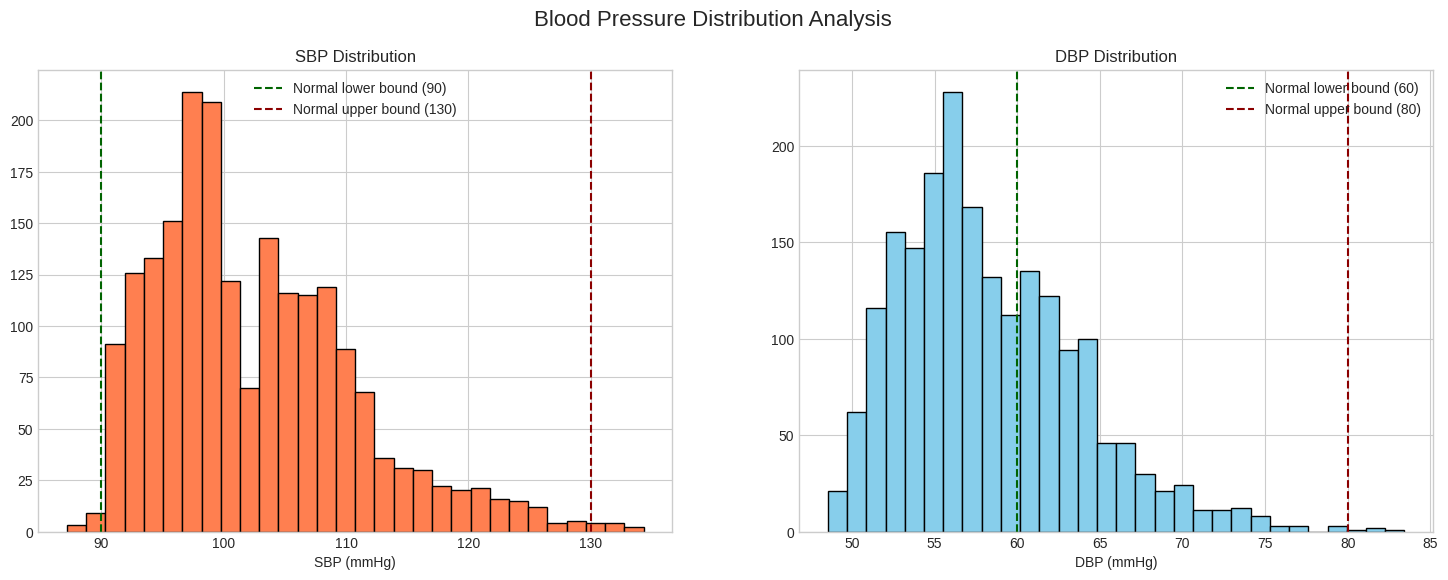


--- 최종 분석 결과 ---
❌ 이 환자는 정상 혈압 범위와 차이가 커 보입니다. 다른 환자를 찾아보는 것을 고려해 보세요.


In [ ]:
# ===== 실행 부분 =====
# 1. 다운로드한 환자 .mat 파일의 전체 경로를 여기에 입력하세요.
# 예시: PATIENT_FILE_PATH = '/content/PulseDB_MIMIC/p012345.mat'
PATIENT_FILE_PATH = '/content/drive/MyDrive/Colab Notebooks/p001331.mat' # 여기에 본인의 파일 경로를 입력

# 2. 분석 함수 실행
analyze_patient_blood_pressure(PATIENT_FILE_PATH)

'/content/drive/MyDrive/Colab Notebooks/p001331.mat' 파일의 Fold별 데이터 분포 분석을 시작합니다...

각 Fold별 혈압 통계:
--------------------------------------------------
Fold  | SBP Mean   | SBP Std    | DBP Mean   | DBP Std   
--------------------------------------------------
Fold 1  | 100.45     | 5.29       | 56.07      | 3.12      
Fold 2  | 96.26      | 4.39       | 54.06      | 3.39      
Fold 3  | 98.59      | 4.92       | 56.06      | 3.33      
Fold 4  | 103.84     | 5.78       | 59.76      | 3.55      
Fold 5  | 113.46     | 7.14       | 65.56      | 4.44      
--------------------------------------------------


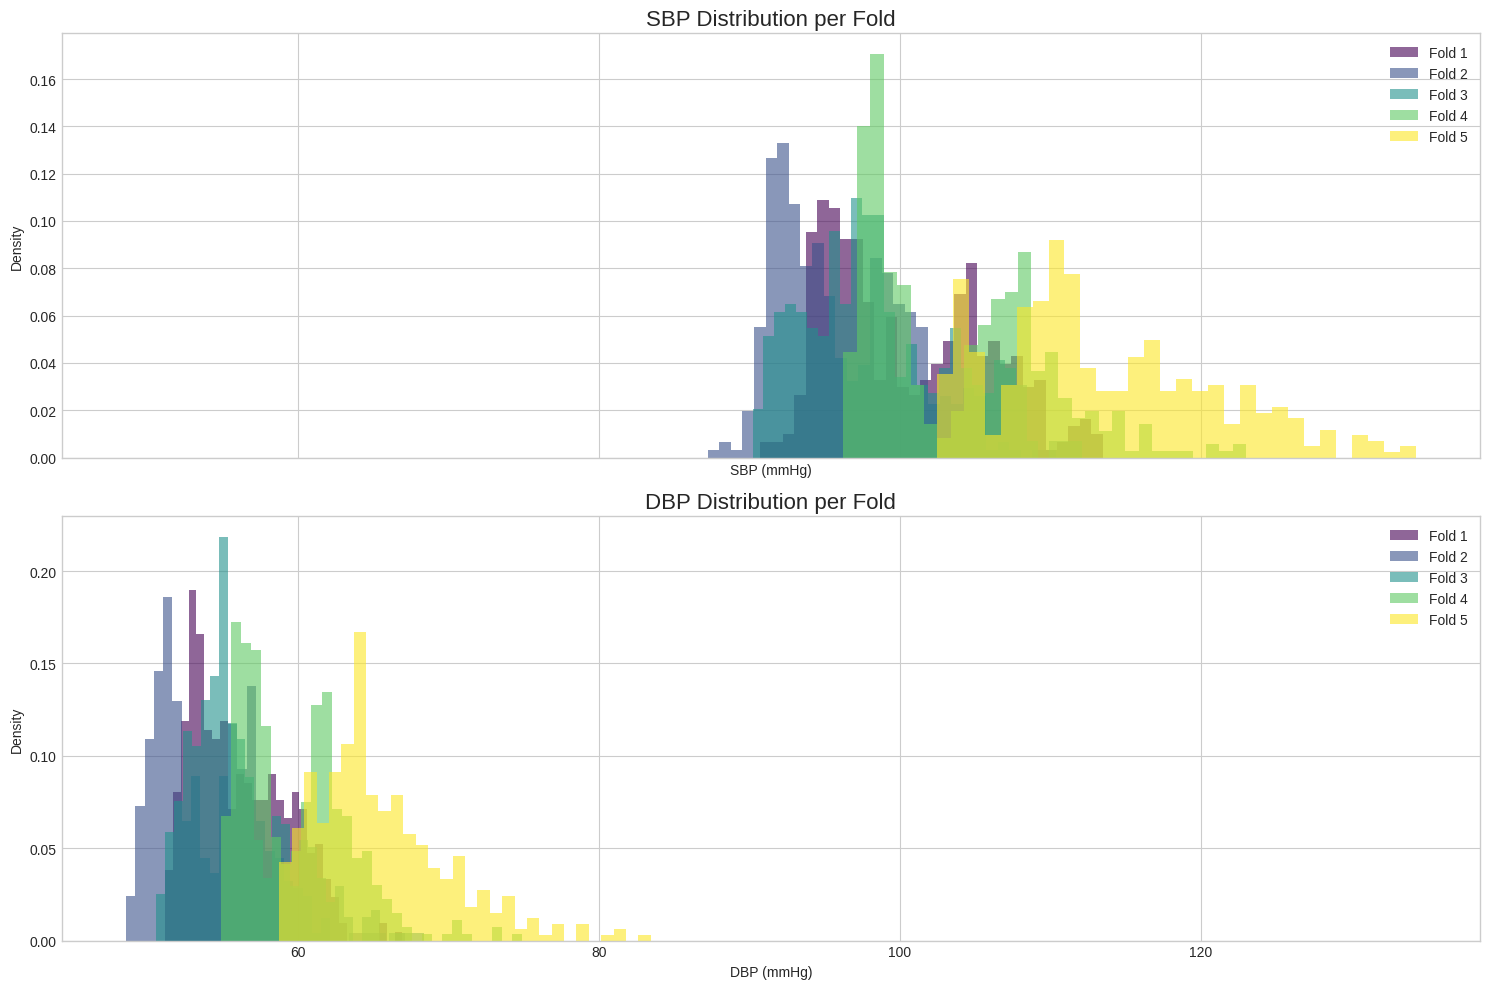

In [ ]:
# ===== 설정 =====
# 분석할 환자 .mat 파일의 경로를 지정하세요.
PATIENT_FILE_PATH = '/content/drive/MyDrive/Colab Notebooks/p001331.mat'

def analyze_fold_distribution(file_path):
    """
    환자 데이터를 5-Fold로 나누어 각 Fold별 SBP, DBP 분포를 시각화합니다.
    """
    print(f"'{file_path}' 파일의 Fold별 데이터 분포 분석을 시작합니다...")

    try:
        with h5py.File(file_path, 'r') as f:
            if 'Subj_Wins' not in f or 'SegSBP' not in f['Subj_Wins']:
                print("오류: 파일이 유효한 PulseDB 형식이 아닙니다.")
                return

            sbp_refs = f['Subj_Wins']['SegSBP'][0]
            dbp_refs = f['Subj_Wins']['SegDBP'][0]

            num_segments_to_load = min(len(sbp_refs), 2000)
            if num_segments_to_load < 2000:
                print(f"경고: 세그먼트 수가 {num_segments_to_load}개로 2000개 미만입니다.")
                return

            sbps = np.array([float(f[ref][()][0, 0]) for ref in sbp_refs[:num_segments_to_load]])
            dbps = np.array([float(f[ref][()][0, 0]) for ref in dbp_refs[:num_segments_to_load]])

            n_splits = 5
            fold_size = 400

            # SBP, DBP 분포를 그릴 준비
            fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
            colors = plt.cm.viridis(np.linspace(0, 1, n_splits))

            print("\n각 Fold별 혈압 통계:")
            print("-" * 50)
            print(f"{'Fold':<5} | {'SBP Mean':<10} | {'SBP Std':<10} | {'DBP Mean':<10} | {'DBP Std':<10}")
            print("-" * 50)

            for i in range(n_splits):
                fold_start = i * fold_size
                fold_end = fold_start + fold_size

                sbp_fold = sbps[fold_start:fold_end]
                dbp_fold = dbps[fold_start:fold_end]

                # 통계 출력
                print(f"Fold {i+1:<2} | {np.mean(sbp_fold):<10.2f} | {np.std(sbp_fold):<10.2f} | {np.mean(dbp_fold):<10.2f} | {np.std(dbp_fold):<10.2f}")

                # 히스토그램 그리기 (밀도 플롯)
                axes[0].hist(sbp_fold, bins=30, density=True, color=colors[i], alpha=0.6, label=f'Fold {i+1}')
                axes[1].hist(dbp_fold, bins=30, density=True, color=colors[i], alpha=0.6, label=f'Fold {i+1}')

            print("-" * 50)

            axes[0].set_title('SBP Distribution per Fold', fontsize=16)
            axes[0].set_xlabel('SBP (mmHg)')
            axes[0].set_ylabel('Density')
            axes[0].legend()

            axes[1].set_title('DBP Distribution per Fold', fontsize=16)
            axes[1].set_xlabel('DBP (mmHg)')
            axes[1].set_ylabel('Density')
            axes[1].legend()

            plt.tight_layout()
            plt.show()

    except Exception as e:
        print(f"파일 분석 중 오류가 발생했습니다: {e}")


# ===== 실행 부분 =====
analyze_fold_distribution(PATIENT_FILE_PATH)

In [ ]:
# ===================================================================
# 1. 설정 (Configuration)
# ===================================================================
# 분석할 환자 .mat 파일의 전체 경로를 지정하세요.
TRAIN_PATIENT_PATH = '/content/drive/MyDrive/Colab Notebooks/p001331.mat' # 환자 A (훈련 및 교차 검증용)
TEST_PATIENT_PATH = '/content/drive/MyDrive/Colab Notebooks/p007629.mat'  # 환자 B (최종 테스트용)

# 훈련된 모델 가중치와 스케일러를 저장/로드할 경로
SAVED_MODEL_PATH = './best_model_on_A.pth'
SAVED_SCALER_PATH = './scaler_A.pkl'

# 실험 모드를 선택하세요: 'PPG_ONLY' 또는 'PPG_ECG'
MODE = 'PPG_ONLY'

# 모델 아키텍처 선택: 'CNN_ONLY', 'CNN_LSTM_ATTENTION', 또는 'CNN_TRANSFORMER'
MODEL_ARCHITECTURE = 'CNN_TRANSFORMER'

# Bandpass 필터링 적용 여부
APPLY_BANDPASS_FILTER = False

# ===== 안정성 향상을 위한 추가 설정 =====
USE_BATCH_NORM = True
APPLY_AUGMENTATION = True
WEIGHT_DECAY = 1e-4
USE_LR_SCHEDULER = True
GRADIENT_CLIPPING_VALUE = 1.0

# 하이퍼파라미터
#NUM_EPOCHS = 60
NUM_EPOCHS_CV = 50 # 교차 검증 시 에포크
NUM_EPOCHS_FINAL = 70 # 최종 모델 저장 시 에포크 (조금 더 학습)
BATCH_SIZE = 32
LEARNING_RATE = 0.001
SAMPLING_RATE = 125

# ===== 트랜스포머 고급 설정 (성능 향상용) =====
#D_MODEL = 64
#N_HEAD = 4
#NUM_LAYERS = 2

## Data Augmentaiton 설정

In [ ]:
# ===================================================================
# 2. 데이터 로딩 및 전처리 함수 (동일)
# ===================================================================
def apply_bandpass_filter(signal, lowcut=0.5, highcut=8.0, fs=SAMPLING_RATE, order=4):
    nyq = 0.5 * fs
    low, high = lowcut / nyq, highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

def augment_signal(signal, noise_factor=0.02):
    noise = np.random.normal(0, np.std(signal) * noise_factor, signal.shape)
    return signal + noise

def load_bp_data(file_path, mode='PPG_ONLY', apply_filter=False):
    print(f"'{mode}' 모드로 데이터 로딩을 시작합니다...")
    with h5py.File(file_path, 'r') as f:
        sbp_refs, dbp_refs, ppg_refs = f['Subj_Wins']['SegSBP'][0], f['Subj_Wins']['SegDBP'][0], f['Subj_Wins']['PPG_F'][0]
        num_segments = min(len(sbp_refs), 2000)
        if num_segments < 2000:
            raise ValueError(f"오류: 환자 파일에 {num_segments}개의 세그먼트만 있습니다. 최소 2000개가 필요합니다.")

        sbps = np.array([float(f[ref][()][0, 0]) for ref in sbp_refs[:num_segments]], dtype=np.float32)
        dbps = np.array([float(f[ref][()][0, 0]) for ref in dbp_refs[:num_segments]], dtype=np.float32)
        ppgs = np.array([f[ref][()].squeeze().astype(np.float32) for ref in ppg_refs[:num_segments]])
        Y = np.vstack([sbps, dbps]).T

        if apply_filter:
            print("신호에 Bandpass 필터를 적용합니다...")
            ppgs = np.array([apply_bandpass_filter(s) for s in ppgs])

        if mode == 'PPG_ONLY':
            X = np.expand_dims(ppgs, axis=1)
        elif mode == 'PPG_ECG':
            ecg_refs = f['Subj_Wins']['ECG_F'][0]
            ecgs = np.array([f[ref][()].squeeze().astype(np.float32) for ref in ecg_refs[:num_segments]])
            if apply_filter:
                ecgs = np.array([apply_bandpass_filter(s) for s in ecgs])
            X = np.stack([ppgs, ecgs], axis=1)
        else:
            raise ValueError("Mode는 'PPG_ONLY' 또는 'PPG_ECG' 여야 합니다.")

    print(f"데이터 로딩 완료: X 형태={X.shape}, Y 형태={Y.shape}")
    return X, Y

In [ ]:
# ===================================================================
# 3. 모델 정의 (트랜스포머 모델 추가)
# ===================================================================
class Conv1DNet(nn.Module):
    def __init__(self, input_channels=1, use_batch_norm=True):
        super(Conv1DNet, self).__init__()
        self.use_batch_norm = use_batch_norm
        self.cnn_extractor = nn.Sequential(
            nn.Conv1d(input_channels, 32, 7, padding=3),
            nn.BatchNorm1d(32) if use_batch_norm else nn.Identity(),
            nn.ReLU(),
            nn.MaxPool1d(2, 2),
            nn.Conv1d(32, 64, 5, padding=2),
            nn.BatchNorm1d(64) if use_batch_norm else nn.Identity(),
            nn.ReLU(),
            nn.MaxPool1d(2, 2),
            nn.Conv1d(64, 128, 3, padding=1),
            nn.BatchNorm1d(128) if use_batch_norm else nn.Identity(),
            nn.ReLU()
        )
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc_block = nn.Sequential(nn.Linear(128, 64), nn.ReLU(), nn.Dropout(0.5), nn.Linear(64, 2))
    def forward(self, x):
        x = self.cnn_extractor(x)
        x = self.global_pool(x).view(x.size(0), -1)
        return self.fc_block(x)

class Attention(nn.Module):
    def __init__(self, feature_dim):
        super(Attention, self).__init__()
        self.attention_layer = nn.Sequential(
            nn.Linear(feature_dim, feature_dim),
            nn.Tanh(),
            nn.Linear(feature_dim, 1)
        )

    def forward(self, x):
        attention_weights = self.attention_layer(x)
        attention_weights = F.softmax(attention_weights, dim=1)
        context_vector = torch.sum(attention_weights * x, dim=1)
        return context_vector

class Conv1DLSTMNet(nn.Module):
    def __init__(self, input_channels=1, lstm_hidden_size=64, use_batch_norm=True):
        super(Conv1DLSTMNet, self).__init__()
        self.use_batch_norm = use_batch_norm
        self.cnn_extractor = nn.Sequential(
            nn.Conv1d(input_channels, 32, 7, padding=3),
            nn.BatchNorm1d(32) if use_batch_norm else nn.Identity(),
            nn.ReLU(),
            nn.MaxPool1d(2, 2),
            nn.Conv1d(32, 64, 5, padding=2),
            nn.BatchNorm1d(64) if use_batch_norm else nn.Identity(),
            nn.ReLU(),
            nn.MaxPool1d(2, 2)
        )
        self.lstm = nn.LSTM(64, lstm_hidden_size, 1, batch_first=True, bidirectional=True)
        self.attention = Attention(lstm_hidden_size * 2)
        self.fc_block = nn.Sequential(nn.Linear(lstm_hidden_size * 2, 64), nn.ReLU(), nn.Dropout(0.5), nn.Linear(64, 2))
    def forward(self, x):
        x = self.cnn_extractor(x).permute(0, 2, 1)
        lstm_out, _ = self.lstm(x)
        context_vector = self.attention(lstm_out)
        return self.fc_block(context_vector)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

class PositionalEncoding(nn.Module):
    # ... (생략)
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)
    def forward(self, x):
        return x + self.pe[:x.size(0), :]

class ConvTransformerNet(nn.Module):
    def __init__(self, input_channels=1, d_model=64, nhead=4, num_layers=2, use_batch_norm=True):
        super(ConvTransformerNet, self).__init__()
        # CNN extractor: d_model에 맞춰 채널 수 조절
        self.cnn_extractor = nn.Sequential(
            nn.Conv1d(input_channels, d_model // 2, 7, padding=3),
            nn.BatchNorm1d(d_model // 2) if use_batch_norm else nn.Identity(),
            nn.ReLU(),
            nn.MaxPool1d(2, 2),
            nn.Conv1d(d_model // 2, d_model, 5, padding=2),
            nn.BatchNorm1d(d_model) if use_batch_norm else nn.Identity(),
            nn.ReLU(),
            nn.MaxPool1d(2, 2)
        )
        self.pos_encoder = PositionalEncoding(d_model)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward=d_model*2, dropout=0.4, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.fc_block = nn.Sequential(nn.Linear(d_model, 64), nn.ReLU(), nn.Dropout(0.5), nn.Linear(64, 2))
        self.d_model = d_model

    def forward(self, x):
        x = self.cnn_extractor(x).permute(0, 2, 1)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        return self.fc_block(x)

In [ ]:
# ===================================================================
# 4. 유틸리티 및 시각화 함수 (동일)
# ===================================================================
def plot_learning_curves(history, fold_num):
    plt.figure(figsize=(10, 5))
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(f'Fold {fold_num} - Learning Curves (Loss over Epochs)')
    plt.xlabel('Epoch'), plt.ylabel('MAE Loss'), plt.legend(), plt.grid(True)
    plt.show()

def plot_overall_regression_results(y_true, y_pred, patient_id, title_prefix):
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'Overall Model Performance for Patient {patient_id} (All Folds Combined)', fontsize=16)

    # SBP
    sbp_true, sbp_pred = y_true[:, 0], y_pred[:, 0]
    axes[0, 0].scatter(sbp_true, sbp_pred, alpha=0.5, c='royalblue')
    axes[0, 0].plot([min(sbp_true), max(sbp_true)], [min(sbp_true), max(sbp_true)], 'r--', label='y=x')
    axes[0, 0].set_title('SBP: Predicted vs. Actual'), axes[0, 0].set_xlabel('Actual SBP'), axes[0, 0].set_ylabel('Predicted SBP'), axes[0, 0].grid(True), axes[0, 0].legend()

    sbp_residuals = sbp_true - sbp_pred
    axes[0, 1].scatter(sbp_pred, sbp_residuals, alpha=0.5, c='coral')
    axes[0, 1].axhline(y=0, color='r', linestyle='--')
    axes[0, 1].set_title('SBP: Residuals vs. Predicted'), axes[0, 1].set_xlabel('Predicted SBP'), axes[0, 1].set_ylabel('Residuals'), axes[0, 1].grid(True)

    # DBP
    dbp_true, dbp_pred = y_true[:, 1], y_pred[:, 1]
    axes[1, 0].scatter(dbp_true, dbp_pred, alpha=0.5, c='mediumseagreen')
    axes[1, 0].plot([min(dbp_true), max(dbp_true)], [min(dbp_true), max(dbp_true)], 'r--', label='y=x')
    axes[1, 0].set_title('DBP: Predicted vs. Actual'), axes[1, 0].set_xlabel('Actual DBP'), axes[1, 0].set_ylabel('Predicted DBP'), axes[1, 0].grid(True), axes[1, 0].legend()

    dbp_residuals = dbp_true - dbp_pred
    axes[1, 1].scatter(dbp_pred, dbp_residuals, alpha=0.5, c='orchid')
    axes[1, 1].axhline(y=0, color='r', linestyle='--')
    axes[1, 1].set_title('DBP: Residuals vs. Predicted'), axes[1, 1].set_xlabel('Predicted DBP'), axes[1, 1].set_ylabel('Residuals'), axes[1, 1].grid(True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def plot_regression_results(y_true, y_pred, patient_id, title_prefix):
    fig, axes = plt.subplots(2, 2, figsize=(15, 12)); fig.suptitle(f'{title_prefix} for Patient {patient_id}', fontsize=16); sbp_true, sbp_pred = y_true[:,0], y_pred[:,0]; axes[0,0].scatter(sbp_true, sbp_pred, alpha=0.5, c='royalblue'); axes[0,0].plot([sbp_true.min(), sbp_true.max()], [sbp_true.min(), sbp_true.max()], 'r--', label='y=x'); axes[0,0].set_title('SBP: Predicted vs. Actual'); axes[0,0].set_xlabel('Actual SBP'); axes[0,0].set_ylabel('Predicted SBP'); axes[0,0].grid(True); axes[0,0].legend(); axes[0,1].scatter(sbp_pred, sbp_true-sbp_pred, alpha=0.5, c='coral'); axes[0,1].axhline(y=0, color='r', linestyle='--'); axes[0,1].set_title('SBP: Residuals vs. Predicted'); axes[0,1].set_xlabel('Predicted SBP'); axes[0,1].set_ylabel('Residuals'); axes[0,1].grid(True); dbp_true, dbp_pred = y_true[:,1], y_pred[:,1]; axes[1,0].scatter(dbp_true, dbp_pred, alpha=0.5, c='mediumseagreen'); axes[1,0].plot([dbp_true.min(), dbp_true.max()], [dbp_true.min(), dbp_true.max()], 'r--', label='y=x'); axes[1,0].set_title('DBP: Predicted vs. Actual'); axes[1,0].set_xlabel('Actual DBP'); axes[1,0].set_ylabel('Predicted DBP'); axes[1,0].grid(True); axes[1,0].legend(); axes[1,1].scatter(dbp_pred, dbp_true-dbp_pred, alpha=0.5, c='orchid'); axes[1,1].axhline(y=0, color='r', linestyle='--'); axes[1,1].set_title('DBP: Residuals vs. Predicted'); axes[1,1].set_xlabel('Predicted DBP'); axes[1,1].set_ylabel('Residuals'); axes[1,1].grid(True); plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()


In [ ]:
# ===================================================================
# 5. 환자 A 학습 및 모델 저장 함수
# ===================================================================
def train_and_save_model(train_patient_path):
    print("\n===== 환자 A 데이터 전체 학습 및 최적 모델 저장 시작 =====")
    patient_id_A = os.path.basename(train_patient_path).replace('.mat', '')
    print(f"훈련 환자: {patient_id_A}")

    X_A, Y_A = load_bp_data(train_patient_path, mode=MODE, apply_filter=APPLY_BANDPASS_FILTER)

    # 환자 A 전체 데이터를 훈련(1600) 및 검증(400)용으로 분할
    train_split = 1600
    X_train, Y_train = X_A[:train_split], Y_A[:train_split]
    X_val, Y_val = X_A[train_split:], Y_A[train_split:]

    if APPLY_AUGMENTATION:
        print("훈련 데이터에 증강 적용 중...")
        X_train_aug = np.array([augment_signal(s) for s in X_train.squeeze()]).reshape(X_train.shape)
        X_train = np.concatenate([X_train, X_train_aug], axis=0)
        Y_train = np.concatenate([Y_train, Y_train], axis=0) # 라벨도 두 배로

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
    X_val_scaled = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)

    joblib.dump(scaler, SAVED_SCALER_PATH)
    print(f"스케일러 저장 완료: {SAVED_SCALER_PATH}")

    train_loader = DataLoader(TensorDataset(torch.from_numpy(X_train_scaled).float(), torch.from_numpy(Y_train)), batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(TensorDataset(torch.from_numpy(X_val_scaled).float(), torch.from_numpy(Y_val)), batch_size=BATCH_SIZE)

    # 모델 선택
    if MODEL_ARCHITECTURE == 'CNN_ONLY':
        model = Conv1DNet(input_channels=X_A.shape[1], use_batch_norm=USE_BATCH_NORM).to(device)
    elif MODEL_ARCHITECTURE == 'CNN_LSTM_ATTENTION':
        model = Conv1DLSTMNet(input_channels=X_A.shape[1], use_batch_norm=USE_BATCH_NORM).to(device)
    elif MODEL_ARCHITECTURE == 'CNN_TRANSFORMER':
        model = ConvTransformerNet(input_channels=X_A.shape[1], use_batch_norm=USE_BATCH_NORM).to(device)
    else: raise ValueError("잘못된 MODEL_ARCHITECTURE")

    print(f"모델({MODEL_ARCHITECTURE}) 학습 시작...")
    criterion = nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

    best_val_loss = float('inf')
    best_model_wts = None

    for epoch in range(NUM_EPOCHS_FINAL): # 최종 저장용 에포크 사용
        model.train()
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad(); outputs = model(inputs); loss = criterion(outputs, targets)
            loss.backward(); torch.nn.utils.clip_grad_norm_(model.parameters(), GRADIENT_CLIPPING_VALUE); optimizer.step()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                val_loss += criterion(model(inputs.to(device)), targets.to(device)).item()
        avg_val_loss = val_loss / len(val_loader)

        if (epoch + 1) % 10 == 0:
             print(f"Epoch {epoch+1}/{NUM_EPOCHS_FINAL}, Val Loss: {avg_val_loss:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            print(f"  -> 검증 손실 개선됨: {best_val_loss:.4f}, 모델 가중치 임시 저장")

        if USE_LR_SCHEDULER: scheduler.step(avg_val_loss)

    # 가장 좋았던 모델 가중치 저장
    if best_model_wts:
        torch.save(best_model_wts, SAVED_MODEL_PATH)
        print(f"\n최적 모델 가중치 저장 완료 (Val Loss: {best_val_loss:.4f}): {SAVED_MODEL_PATH}")
    else:
        print("\n경고: 최적 모델 가중치를 찾지 못했습니다. 마지막 에포크의 모델을 저장합니다.")
        torch.save(model.state_dict(), SAVED_MODEL_PATH)

In [ ]:
# ===================================================================
# 6. 저장된 모델 로드 및 환자 B 테스트 함수
# ===================================================================
def test_saved_model_on_B(test_patient_path):
    print("\n===== 저장된 모델 로드 및 환자 B 데이터 테스트 시작 =====")
    patient_id_B = os.path.basename(test_patient_path).replace('.mat', '')
    print(f"테스트 환자: {patient_id_B}")

    # 환자 B 데이터 로드 (필터만 적용, 증강 X)
    X_test_B, Y_test_B = load_bp_data(test_patient_path, mode=MODE, apply_filter=APPLY_BANDPASS_FILTER)

    # 환자 A 학습 시 저장된 스케일러 로드
    if not os.path.exists(SAVED_SCALER_PATH):
        print(f"오류: 스케일러 파일({SAVED_SCALER_PATH}) 없음. 환자 A 학습을 먼저 수행하세요.")
        return
    scaler = joblib.load(SAVED_SCALER_PATH)
    print(f"스케일러 로드 완료: {SAVED_SCALER_PATH}")

    # 환자 B 데이터 스케일링 (환자 A의 스케일러 사용)
    X_test_B_scaled = scaler.transform(X_test_B.reshape(-1, X_test_B.shape[-1])).reshape(X_test_B.shape)

    # 모델 구조 생성 및 저장된 가중치 로드
    if not os.path.exists(SAVED_MODEL_PATH):
        print(f"오류: 모델 가중치 파일({SAVED_MODEL_PATH}) 없음. 환자 A 학습을 먼저 수행하세요.")
        return

    if MODEL_ARCHITECTURE == 'CNN_ONLY':
        model = Conv1DNet(input_channels=X_test_B.shape[1], use_batch_norm=USE_BATCH_NORM).to(device)
    elif MODEL_ARCHITECTURE == 'CNN_LSTM_ATTENTION':
        model = Conv1DLSTMNet(input_channels=X_test_B.shape[1], use_batch_norm=USE_BATCH_NORM).to(device)
    elif MODEL_ARCHITECTURE == 'CNN_TRANSFORMER':
        model = ConvTransformerNet(input_channels=X_test_B.shape[1], d_model=D_MODEL, nhead=N_HEAD, num_layers=NUM_LAYERS, use_batch_norm=USE_BATCH_NORM).to(device)
    else: raise ValueError("잘못된 MODEL_ARCHITECTURE")

    model.load_state_dict(torch.load(SAVED_MODEL_PATH))
    model.eval()
    print(f"모델 가중치 로드 완료: {SAVED_MODEL_PATH}")

    # 예측 수행
    with torch.no_grad():
        Y_pred_B = model(torch.from_numpy(X_test_B_scaled).float().to(device)).cpu().numpy()

    # 성능 계산
    sbp_mae = mean_absolute_error(Y_test_B[:, 0], Y_pred_B[:, 0])
    sbp_rmse = np.sqrt(mean_squared_error(Y_test_B[:, 0], Y_pred_B[:, 0]))
    dbp_mae = mean_absolute_error(Y_test_B[:, 1], Y_pred_B[:, 1])
    dbp_rmse = np.sqrt(mean_squared_error(Y_test_B[:, 1], Y_pred_B[:, 1]))

    print("\n--- 환자 B 테스트 결과 (Inter-patient) ---")
    print(f"모델 설정: {MODE}, {MODEL_ARCHITECTURE}, Filter: {APPLY_BANDPASS_FILTER}, Augment(Train): {APPLY_AUGMENTATION}, BN: {USE_BATCH_NORM}")
    print(f"SBP MAE: {sbp_mae:.2f}, SBP RMSE: {sbp_rmse:.2f}")
    print(f"DBP MAE: {dbp_mae:.2f}, DBP RMSE: {dbp_rmse:.2f}")

    # 시각화
    plot_regression_results(Y_test_B, Y_pred_B, patient_id_B, title_prefix="Inter-Patient Test Result")

===== 메인 실행 시작 (Device: cuda) =====

===== 단계 1: 환자 A 교차 검증 시작 =====
'PPG_ONLY' 모드로 데이터 로딩을 시작합니다...
데이터 로딩 완료: X 형태=(2000, 1, 1250), Y 형태=(2000, 2)

--- 교차 검증 Fold 1/4 ---
  교차 검증 Fold 1 결과 -> SBP MAE: 5.41, RMSE: 6.22 | DBP MAE: 4.10, RMSE: 4.45

--- 교차 검증 Fold 2/4 ---
  교차 검증 Fold 2 결과 -> SBP MAE: 3.41, RMSE: 3.68 | DBP MAE: 2.29, RMSE: 2.51

--- 교차 검증 Fold 3/4 ---
  교차 검증 Fold 3 결과 -> SBP MAE: 3.84, RMSE: 4.40 | DBP MAE: 2.54, RMSE: 2.97

--- 교차 검증 Fold 4/4 ---
  교차 검증 Fold 4 결과 -> SBP MAE: 5.77, RMSE: 6.75 | DBP MAE: 3.09, RMSE: 3.58

===== 환자 A 교차 검증 결과 요약 =====
Patient ID: p001331, Mode: PPG_ONLY, Model: CNN_TRANSFORMER, Filter: False, Augment: True, BN: True

--- Fold-wise Metrics (Intra-patient) ---
Fold 1: SBP MAE=5.41, RMSE=6.22 | DBP MAE=4.10, RMSE=4.45
Fold 2: SBP MAE=3.41, RMSE=3.68 | DBP MAE=2.29, RMSE=2.51
Fold 3: SBP MAE=3.84, RMSE=4.40 | DBP MAE=2.54, RMSE=2.97
Fold 4: SBP MAE=5.77, RMSE=6.75 | DBP MAE=3.09, RMSE=3.58

--- Average Metrics (4-Fold, Intra-patient) ---
S

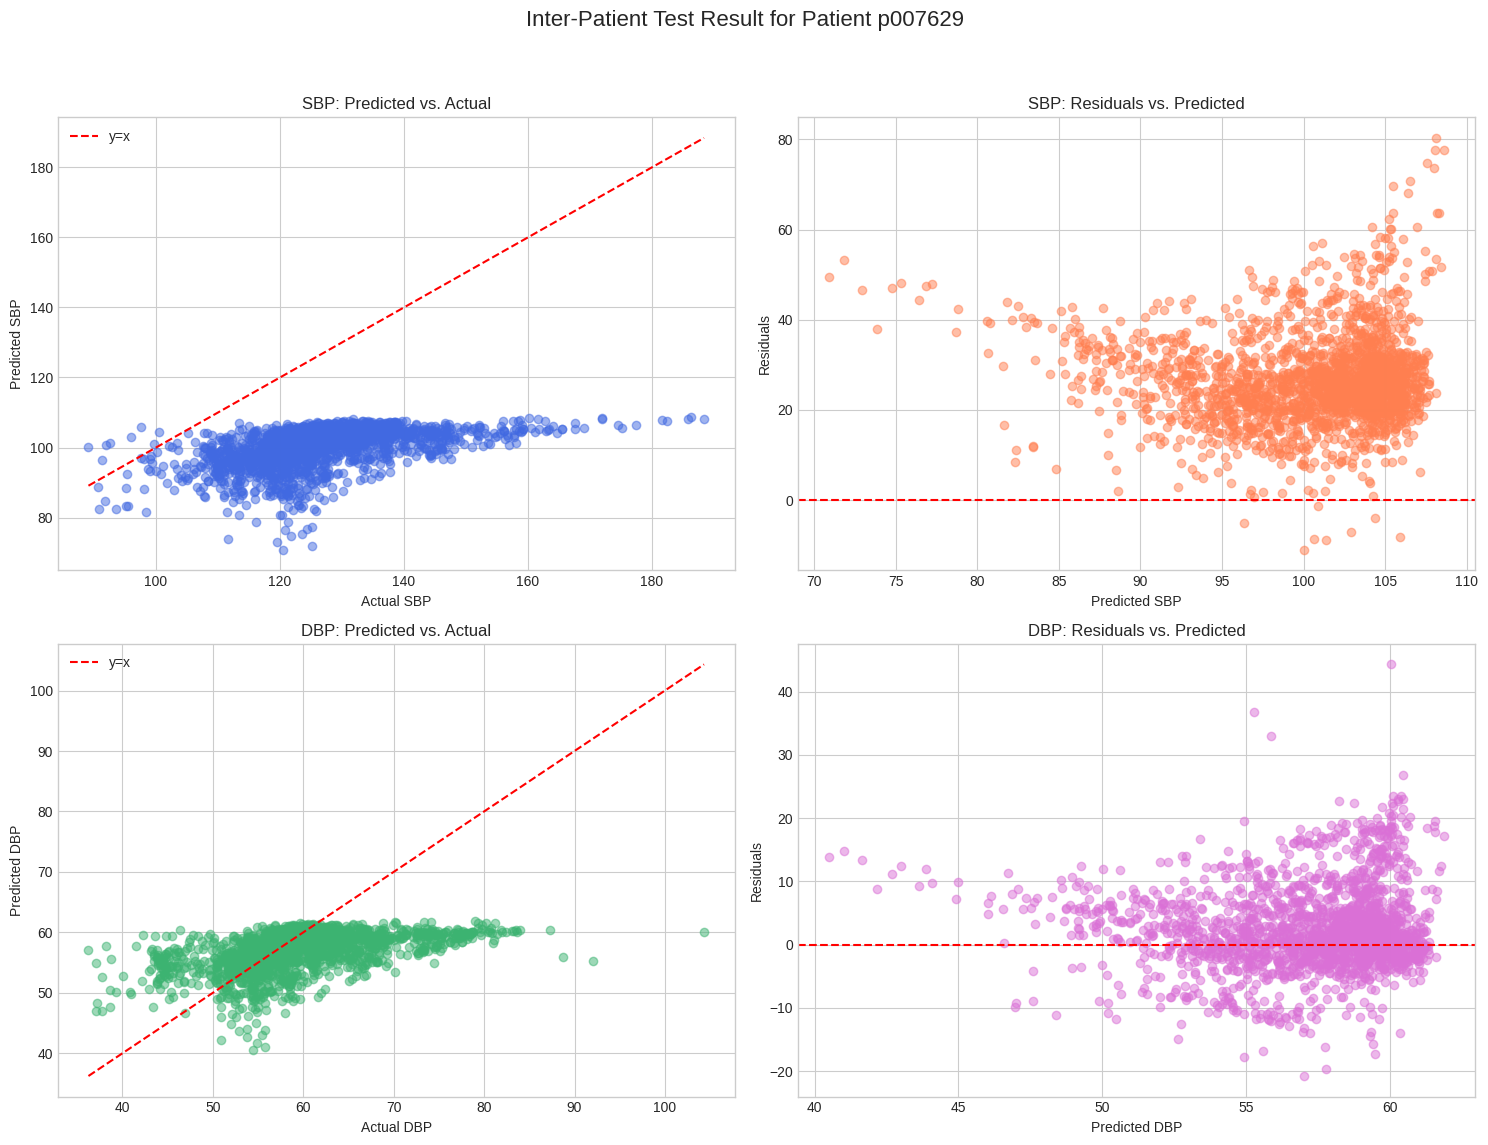


===== 모든 작업 완료 =====


In [ ]:
# ===================================================================
# 7. 메인 실행 블록 (환자 A 교차검증 -> 환자 A 전체학습/저장 -> 환자 B 테스트) - 수정
# ===================================================================
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"===== 메인 실행 시작 (Device: {device}) =====")

    # --- 단계 1: 환자 A에 대한 교차 검증 (Intra-patient) ---
    print("\n===== 단계 1: 환자 A 교차 검증 시작 =====")
    try:
        X_data_A, Y_data_A = load_bp_data(TRAIN_PATIENT_PATH, mode=MODE, apply_filter=APPLY_BANDPASS_FILTER)
    except (FileNotFoundError, ValueError) as e:
        print(e); exit()

    patient_id_A = os.path.basename(TRAIN_PATIENT_PATH).replace('.mat', '')

    # ===== 수정된 부분: 4-Fold 설정 (350/50/100 분할) =====
    n_splits_cv = 4
    fold_size_cv = 500
    train_size_cv, val_size_cv, test_size_cv = 350, 50, 100

    fold_metrics_A = []; all_y_true_A_cv, all_y_pred_A_cv = [], []

    if 'X_data_A' in locals():
        for i in range(n_splits_cv):
            print(f"\n--- 교차 검증 Fold {i+1}/{n_splits_cv} ---")

            fold_start = i * fold_size_cv
            train_end = fold_start + train_size_cv
            val_end = train_end + val_size_cv
            test_end = val_end + test_size_cv

            X_train, Y_train = X_data_A[fold_start:train_end], Y_data_A[fold_start:train_end]
            X_val, Y_val = X_data_A[train_end:val_end], Y_data_A[train_end:val_end]
            X_test, Y_test = X_data_A[val_end:test_end], Y_data_A[val_end:test_end]

            if APPLY_AUGMENTATION:
                X_train_aug = np.array([augment_signal(s) for s in X_train.squeeze()]).reshape(X_train.shape)
                X_train = np.concatenate([X_train, X_train_aug], axis=0)
                Y_train = np.concatenate([Y_train, Y_train], axis=0)

            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
            X_val_scaled = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
            X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

            train_loader = DataLoader(TensorDataset(torch.from_numpy(X_train_scaled).float(), torch.from_numpy(Y_train)), batch_size=BATCH_SIZE, shuffle=True)
            val_loader = DataLoader(TensorDataset(torch.from_numpy(X_val_scaled).float(), torch.from_numpy(Y_val)), batch_size=BATCH_SIZE)

            if MODEL_ARCHITECTURE == 'CNN_ONLY': model = Conv1DNet(input_channels=X_data_A.shape[1], use_batch_norm=USE_BATCH_NORM).to(device)
            elif MODEL_ARCHITECTURE == 'CNN_LSTM_ATTENTION': model = Conv1DLSTMNet(input_channels=X_data_A.shape[1], use_batch_norm=USE_BATCH_NORM).to(device)
            elif MODEL_ARCHITECTURE == 'CNN_TRANSFORMER':
                 # FIX: 기본 파라미터로 모델 생성 (d_model=64 등)
                model = ConvTransformerNet(input_channels=X_data_A.shape[1], use_batch_norm=USE_BATCH_NORM).to(device)
            else: raise ValueError("잘못된 MODEL_ARCHITECTURE")

            criterion = nn.L1Loss()
            optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

            history = {'train_loss': [], 'val_loss': []}
            for epoch in range(NUM_EPOCHS_CV): # 교차검증용 에포크 사용
                model.train()
                for inputs, targets in train_loader: inputs, targets = inputs.to(device), targets.to(device); optimizer.zero_grad(); outputs = model(inputs); loss = criterion(outputs, targets); loss.backward(); torch.nn.utils.clip_grad_norm_(model.parameters(), GRADIENT_CLIPPING_VALUE); optimizer.step()
                model.eval(); val_loss = 0
                with torch.no_grad():
                    for inputs, targets in val_loader: val_loss += criterion(model(inputs.to(device)), targets.to(device)).item()
                avg_val_loss = val_loss / len(val_loader)
                history['train_loss'].append(loss.item()); history['val_loss'].append(avg_val_loss)
                if USE_LR_SCHEDULER: scheduler.step(avg_val_loss)

            # plot_learning_curves(history, fold_num=i+1) # 필요시 주석 해제
            model.eval()
            with torch.no_grad(): Y_pred_fold = model(torch.from_numpy(X_test_scaled).float().to(device)).cpu().numpy()

            sbp_mae, sbp_rmse = mean_absolute_error(Y_test[:,0], Y_pred_fold[:,0]), np.sqrt(mean_squared_error(Y_test[:,0], Y_pred_fold[:,0]))
            dbp_mae, dbp_rmse = mean_absolute_error(Y_test[:,1], Y_pred_fold[:,1]), np.sqrt(mean_squared_error(Y_test[:,1], Y_pred_fold[:,1]))
            fold_metrics_A.append({'sbp_mae': sbp_mae, 'sbp_rmse': sbp_rmse, 'dbp_mae': dbp_mae, 'dbp_rmse': dbp_rmse})
            all_y_true_A_cv.append(Y_test); all_y_pred_A_cv.append(Y_pred_fold)
            print(f"  교차 검증 Fold {i+1} 결과 -> SBP MAE: {sbp_mae:.2f}, RMSE: {sbp_rmse:.2f} | DBP MAE: {dbp_mae:.2f}, RMSE: {dbp_rmse:.2f}")

        # --- 환자 A 교차 검증 결과 요약 ---
        print("\n===== 환자 A 교차 검증 결과 요약 ====="); print(f"Patient ID: {patient_id_A}, Mode: {MODE}, Model: {MODEL_ARCHITECTURE}, Filter: {APPLY_BANDPASS_FILTER}, Augment: {APPLY_AUGMENTATION}, BN: {USE_BATCH_NORM}\n"); print("--- Fold-wise Metrics (Intra-patient) ---")
        for i, m in enumerate(fold_metrics_A): print(f"Fold {i+1}: SBP MAE={m['sbp_mae']:.2f}, RMSE={m['sbp_rmse']:.2f} | DBP MAE={m['dbp_mae']:.2f}, RMSE={m['dbp_rmse']:.2f}")
        print("\n--- Average Metrics (4-Fold, Intra-patient) ---"); avg_sbp_mae, std_sbp_mae = np.mean([m['sbp_mae'] for m in fold_metrics_A]), np.std([m['sbp_mae'] for m in fold_metrics_A]); avg_sbp_rmse, std_sbp_rmse = np.mean([m['sbp_rmse'] for m in fold_metrics_A]), np.std([m['sbp_rmse'] for m in fold_metrics_A]); avg_dbp_mae, std_dbp_mae = np.mean([m['dbp_mae'] for m in fold_metrics_A]), np.std([m['dbp_mae'] for m in fold_metrics_A]); avg_dbp_rmse, std_dbp_rmse = np.mean([m['dbp_rmse'] for m in fold_metrics_A]), np.std([m['dbp_rmse'] for m in fold_metrics_A])
        print(f"SBP MAE : {avg_sbp_mae:.2f} ± {std_sbp_mae:.2f}"); print(f"SBP RMSE: {avg_sbp_rmse:.2f} ± {std_sbp_rmse:.2f}"); print(f"DBP MAE : {avg_dbp_mae:.2f} ± {std_dbp_mae:.2f}"); print(f"DBP RMSE: {avg_dbp_rmse:.2f} ± {std_dbp_rmse:.2f}")

    # --- 단계 2: 환자 A 전체 데이터로 최종 모델 학습 및 저장 ---
    train_and_save_model(TRAIN_PATIENT_PATH)

    # --- 단계 3: 저장된 모델로 환자 B 테스트 ---
    test_saved_model_on_B(TEST_PATIENT_PATH)

    print("\n===== 모든 작업 완료 =====")